In [1]:
#-*- coding:utf8-*-
%matplotlib inline

from __future__ import absolute_import, division, print_function, unicode_literals

from IPython.display import Image

import numpy as np

import uncertainties as unc
from uncertainties import unumpy as unp
from uncertainties.unumpy import std_devs as stds #TODO
from uncertainties.unumpy import nominal_values as noms #TODO

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D 

import seaborn as sns
sns.set(context="paper",font_scale=1.4)

import scipy as sp
import scipy.constants as const

import sympy as sym

import pandas as pd

import ROOT as rt

import root_numpy as rnp

from aputils.latextables.tables import Table


# Fehlerfortpflanzung beim Mitteln
umean = unc.wrap(np.mean)

#Laden des Latex fonts 
plt.rcParams['text.latex.preamble']=["\\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

#Größe der Achsenbeschriftung
axis_font = {'size':'14'}

# Pfade
path_graphics = "../Grafiken/"
path_table = "../Tabellen/"
path_data = "../Messdaten/"

In [108]:
current_palette = sns.color_palette()
sns_blue = current_palette[0]  #(0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
sns_green = current_palette[1] #(0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
sns_red = current_palette[2]   #(0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
sns_purple = current_palette[3]#(0.5058823529411764, 0.4470588235294118, 0.6980392156862745)
sns_yellow = current_palette[4]#(0.8, 0.7254901960784313, 0.4549019607843137)
sns_cyan = current_palette[5]  #(0.39215686274509803, 0.7098039215686275, 0.803921568627451)

In [119]:
# Funktionen
# Achsenbeschriftungen
def axis_label(label,sym=None,unit=None):
    if sym == None:
        return label
    elif unit == None:
        return r"".join([label," ${s}$".format(s=sym)])
    else:
        return r"".join([label," ${s}/\mathrm{{{u}}}$".format(s=sym,u=unit)])

    
    
def axis_scale(axis="x",scale=1):
        if axis == "x":
            axis = plt.gca().xaxis
        elif axis == "y":
            axis = plt.gca().yaxis
        axis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,_ : float(x)*scale))

    
# Fit Funktionen
def fit_errors(popt,pcov):
    errors = np.sqrt(np.diag(pcov))
    param_err = unp.uarray(popt,errors)
    return param_err
    
def print_errors(array,description=None):
    if description and len(description)==len(array):
        maxlen = max(map(len,description))
        lens = map(len,description)
        for i,entry in enumerate(array):
            print(description[i]," "*(maxlen-lens[i]),entry.nominal_value,"+/-",entry.std_dev)
    else:
        for i,entry in enumerate(array):
            print(entry.nominal_value,"+/-",entry.std_dev)
            
def apply_error_2_dataframe(dataframe,error,cols=None,relativ=False):
    if cols == None:
        cols = range(len(dataframe))
    columns = np.array(dataframe.columns)
    for col in columns[cols]:
        err = error if not relativ else error*dataframe[col]
        dataframe[col] = unp.uarray(dataframe[col],err)

In [85]:
# R/mm
def helmholtz_coil_field(I,N=156,R=100):
    return 8/np.sqrt(125)*const.mu_0 * ((N*I)/R)

In [86]:
# Laden der Daten
resonance_curve = pd.read_csv(path_data+"Resonanzkurven.csv",comment="#")
errors = pd.read_csv(path_data+"Messfehler.csv",comment="#")

In [87]:
# Fehlerbehaftete Messwerte
resonance_curve_err = resonance_curve.copy()
apply_error_2_dataframe(resonance_curve_err,errors.I,cols=[2,3,4,5])
apply_error_2_dataframe(resonance_curve_err,errors.X,cols=[6,7,8,9])


In [115]:
# Berechnung der Resonanzstellen
resonance_curve_err["dI_P"] = np.abs(resonance_curve_err.I_max_P - resonance_curve_err.I_min_P)
resonance_curve_err["dI_N"] = np.abs(resonance_curve_err.I_max_N - resonance_curve_err.I_min_N)
resonance_curve_err["I_per_d_P"] = resonance_curve_err.dI_P/resonance_curve_err.X_d_P
resonance_curve_err["I_per_d_N"] = resonance_curve_err.dI_N/resonance_curve_err.X_d_N
resonance_curve_err["I_res_P"] = resonance_curve_err.I_min_P + resonance_curve_err.I_per_d_P * resonance_curve_err.X_res_P
resonance_curve_err["I_res_N"] = abs(resonance_curve_err.I_min_N + resonance_curve_err.I_per_d_N * resonance_curve_err.X_res_N)
resonance_curve_err["B_raw_P"] = helmholtz_coil_field(resonance_curve_err.I_res_P.values) 
resonance_curve_err["B_raw_N"] = helmholtz_coil_field(resonance_curve_err.I_res_N.values) 
resonance_curve_err["dB_raw"] = abs(resonance_curve_err.B_raw_P - resonance_curve_err.B_raw_N)
resonance_curve_err["B_earth"] = resonance_curve_err.dB_raw/2
resonance_curve_err["B_real"] =resonance_curve_err.B_raw_P + resonance_curve_err.B_earth

#print(np.mean(noms(resonance_curve_err.B_earth)))
resonance_curve_err["B_real"]#[["dI_P","I_per_d_P","I_res_P","dI_P","X_d_P"]]


0    0.000316+/-0.000006
1    0.000561+/-0.000005
2    0.000706+/-0.000005
3    0.000845+/-0.000005
Name: B_real, dtype: object

In [161]:
res = resonance_curve_err.copy()
# Fit der Messwerte
def linear(x,a,b):
    return a*x + b

X = np.linspace(min(noms(res.B_real)),max(noms(res.B_real)),1000)

popt,pcov = sp.optimize.curve_fit(linear,noms(res.B_real),noms(res.f_e))
params_err = fit_errors(popt,pcov)
print_errors(params_err,["a [MHz/T]","b [MHz]"])


a [MHz/T]  27170.5569932 +/- 2031.35133291
b [MHz]    1.52051720938 +/- 1.29581585756


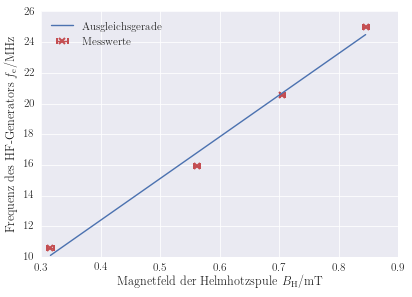

In [142]:

# Plot der Messwerte
plt.errorbar(noms(res.B_real),noms(res.f_e), xerr=stds(res.B_real),
             marker="x",mew=2,linestyle="",color=sns_red,label="Messwerte")
plt.plot(X,linear(X,*popt),label="Ausgleichsgerade")
axis_scale(axis="x",scale=1e03)
plt.xlabel(axis_label("Magnetfeld der Helmhotzspule",sym="B_{\mathrm{H}}",unit="mT"))
plt.ylabel(axis_label("Frequenz des HF-Generators",sym="f_{\mathrm{e}}",unit="MHz"))
plt.legend(loc="upper left")
plt.savefig(path_graphics+"Magenetfeld.pdf")

In [162]:
# Berechnung des Lande Faktors
def calc_lande(a):
    return 2*a*1e06 * (const.m_e/const.e) * (const.h/const.hbar)
print("Lande Faktor des Elektrons:",calc_lande(params_err[0]))

Lande Faktor des Elektrons: 1.94+/-0.15


In [211]:
def calc_mean_error(values):
    mean = np.mean(noms(values))
    std = np.std(noms(values))/np.sqrt(len(values))
    mean_sys = unc.ufloat(mean,std)
    mean_stat = umean(values)
    return mean_sys,mean_stat

In [212]:
#Berechnung des Erdmagentfeldes
B_sys,B_stat = calc_mean_error(resonance_curve_err.B_earth.values)
print("Systematischer Fehler",B_sys)
print("Statistischer Fehler",B_stat)

Systematischer Fehler (6.6+/-1.2)e-05
Statistischer Fehler (6.57+/-0.26)e-05


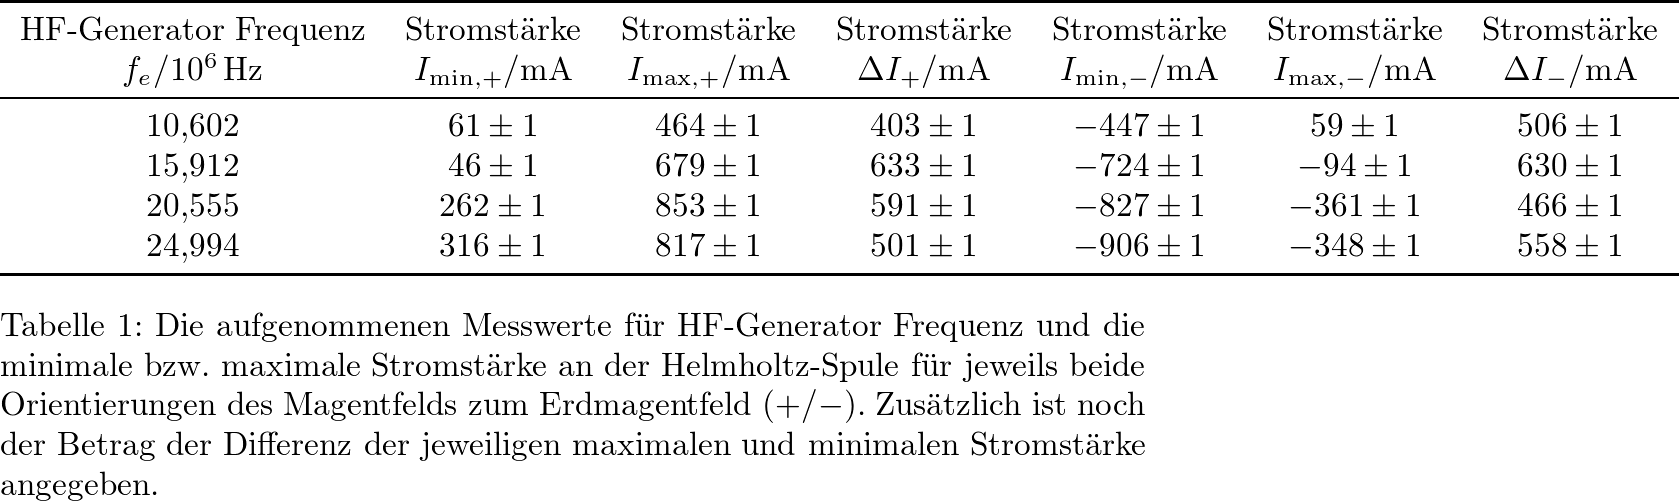

In [234]:
#Tabellen
Tab_I = Table(siunitx=True,booktabs=True)
Tab_I.caption("""Die aufgenommenen Messwerte für HF-Generator Frequenz und die minimale bzw. maximale
Stromstärke an der Helmholtz-Spule für jeweils beide Orientierungen des Magentfelds zum Erdmagentfeld ($+/-$).
Zusätzlich ist noch der Betrag der Differenz der jeweiligen maximalen und minimalen Stromstärke angegeben.""")
Tab_I.label("messwerte_I")
Tab_I.addColumn(resonance_curve_err.f_e,title="HF-Generator Frequenz",symbol="f_e",unit="\mega\hertz")
Tab_I.addColumn(resonance_curve_err.I_min_P,title="Stromstärke",symbol="I_{\mathrm{min,+}}",unit="\milli A")
Tab_I.addColumn(resonance_curve_err.I_max_P,title="Stromstärke",symbol="I_{\mathrm{max,+}}",unit="\milli A")
Tab_I.addColumn(resonance_curve_err.dI_P,title="Stromstärke",symbol="\Delta I_{+}",unit="\milli A")
Tab_I.addColumn(resonance_curve_err.I_min_N,title="Stromstärke",symbol="I_{\mathrm{min,-}}",unit="\milli A")
Tab_I.addColumn(resonance_curve_err.I_max_N,title="Stromstärke",symbol="I_{\mathrm{max,-}}",unit="\milli A")
Tab_I.addColumn(resonance_curve_err.dI_N,title="Stromstärke",symbol="\Delta I_{-}",unit="\milli A")
Image(Tab_I.show(ipynb=True),width=800)
#Tab_I.save(path_table+"Messwerte_I.tex")

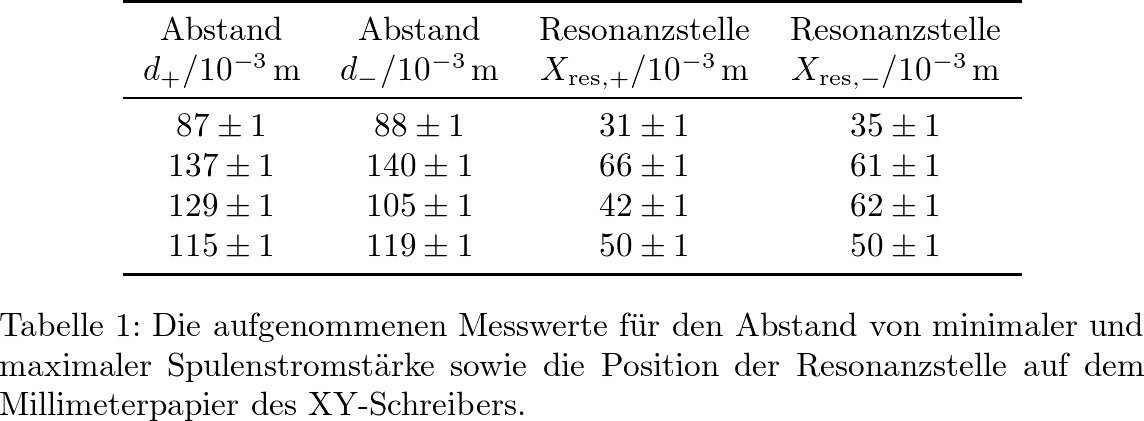

In [226]:
Tab_X = Table(siunitx=True,booktabs=True)
Tab_X.caption("""Die aufgenommenen Messwerte für den Abstand von minimaler und maximaler Spulenstromstärke
sowie die Position der Resonanzstelle auf dem Millimeterpapier des XY-Schreibers.""")
Tab_X.label("messwerte_X")
#Tab_X.addColumn(resonance_curve_err.f_e,title="HF-Generator Frequenz",symbol="f_e",unit="\mega\hertz")
Tab_X.addColumn(resonance_curve_err.X_d_P,title="Abstand",symbol="d_{+}",unit="\milli\meter")
Tab_X.addColumn(resonance_curve_err.X_d_N,title="Abstand",symbol="d_{-}",unit="\milli\meter")
Tab_X.addColumn(resonance_curve_err.X_res_P,title="Resonanzstelle",symbol="X_{\mathrm{res,+}}",unit="\milli\meter")
Tab_X.addColumn(resonance_curve_err.X_res_N,title="Resonanzstelle",symbol="X_{\mathrm{res,-}}",unit="\milli\meter")
Image(Tab_X.show(ipynb=True),width=800)
#Tab_X.save(path_table+"Abstand.tex")

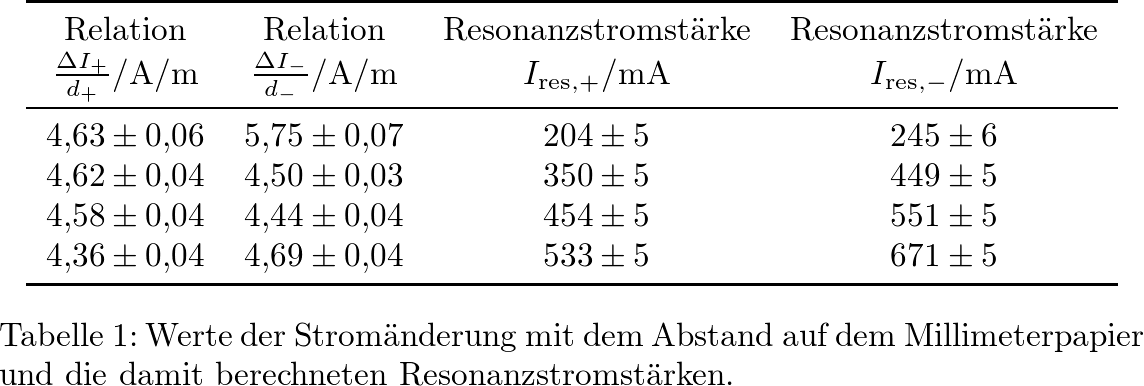

In [228]:
Tab_d = Table(siunitx=True,booktabs=True)
Tab_d.caption("""Werte der Stromänderung mit dem Abstand auf dem Millimeterpapier und die damit 
berechneten Resonanzstromstärken.""")
Tab_d.label("messwerte_d")
#Tab_d.addColumn(resonance_curve_err.f_e,title="HF-Generator Frequenz",symbol="f_e",unit="\mega\hertz")
Tab_d.addColumn(resonance_curve_err.I_per_d_P,title="Relation",symbol="\\frac{\Delta I_{+}}{d_{+}}",unit="A\per\meter")
Tab_d.addColumn(resonance_curve_err.I_per_d_N,title="Relation",symbol="\\frac{\Delta I_{-}}{d_{-}}",unit="A\per\meter")
Tab_d.addColumn(resonance_curve_err.I_res_P,title="Resonanzstromstärke",symbol="I_{\mathrm{res,+}}",unit="\milli A")
Tab_d.addColumn(resonance_curve_err.I_res_N,title="Resonanzstromstärke",symbol="I_{\mathrm{res,-}}",unit="\milli A")
#Tab_d.addColumn(resonance_curve_err.X_res_N,title="Resonanzstelle",symbol="X_{res,-}",unit="\milli\meter")
Image(Tab_d.show(ipynb=True),width=800)
#Tab_d.save(path_table+"Resonanz.tex")

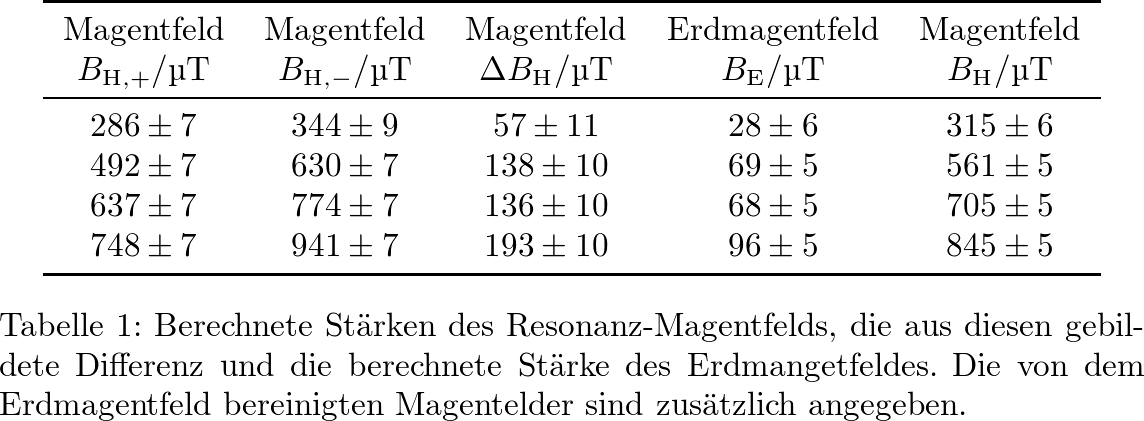

In [233]:
Tab_B = Table(siunitx=True,booktabs=True)
Tab_B.caption("""Berechnete Stärken des Resonanz-Magentfelds, die aus diesen gebildete Differenz und die
berechnete Stärke des Erdmangetfeldes. Die von dem Erdmagentfeld bereinigten Magentelder sind zusätzlich angegeben. """)
Tab_B.label("messwerte_B")
Tab_B.addColumn(resonance_curve_err.B_raw_P*1e06,title="Magentfeld",symbol="B_{\mathrm{H,+}}",unit="\micro T")
Tab_B.addColumn(resonance_curve_err.B_raw_N*1e06,title="Magentfeld",symbol="B_{\mathrm{H,-}}",unit="\micro T")
Tab_B.addColumn(resonance_curve_err.dB_raw*1e06,title="Magentfeld",symbol="\Delta B_{\mathrm{H}}",unit="\micro T")
Tab_B.addColumn(resonance_curve_err.B_earth*1e06,title="Erdmagentfeld",symbol="B_{\mathrm{E}}",unit="\micro T")
Tab_B.addColumn(resonance_curve_err.B_real*1e06,title="Magentfeld",symbol="B_{\mathrm{H}}",unit="\micro T")
#Tab_B.addColumn(resonance_curve_err.X_res_N,title="Resonanzstelle",symbol="X_{res,-}",unit="\milli\meter")
Image(Tab_B.show(ipynb=True),width=800)
#Tab_B.save(path_table+"Magentfeld.tex")